In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 2 — Data Transformation and Encoding
## Lesson 13: Building Preprocessing Pipelines (Fit/Transform Discipline, Column-Wise Pipelines)



### What you will learn

By the end of this lesson, you should be able to:

- Explain *why* preprocessing must be learned only from training data and then reused unchanged on validation/test data.
- Use `Pipeline` to chain multiple preprocessing steps with an estimator in a single, safe object.
- Use `ColumnTransformer` to apply different preprocessing to numeric, categorical, and text columns.
- Diagnose common pipeline failures: shape mismatches, sparse/dense issues, missing-value handling, and feature-name tracking.
- Set up cross-validation and hyperparameter tuning *without* data leakage.

---

### Why pipelines exist (the problem they solve)

In classical machine learning on tabular data, the model rarely consumes the raw table directly. Instead, we apply a sequence of transformations:

- cleaning (missing values, type fixes),
- encoding (categorical to numeric),
- scaling (standardization/normalization),
- feature generation (interaction terms, log transforms, date parts),
- dimensionality reduction (optional).

A dangerous temptation is to do these transformations “once” on the entire dataset and then split into train/test. That breaks the most important rule:

> **Any transformation with learned parameters must be fitted only on training data.**

Examples of learned parameters:

- mean and standard deviation for standardization,
- category-to-index mapping for one-hot encoding,
- vocabulary and IDF weights for TF–IDF,
- imputation statistics (median, most-frequent),
- PCA components.

If those parameters “see” the test set, the transformation becomes a covert channel that leaks information from test to train.

---

### Fit/Transform discipline as a mathematical statement

Let $D = \{(x_i, y_i)\}_{i=1}^n$ be a dataset, split into training and test sets:

$$D_{\text{train}} \cup D_{\text{test}} = D, \quad D_{\text{train}} \cap D_{\text{test}} = \emptyset.$$

A preprocessing step is typically a pair of operations:

- **fit**: estimate parameters $\theta$ from data
- **transform**: apply those parameters to inputs

Formally, a transformer $T$ induces:

$$\theta = \mathrm{fit}(T, X_{\text{train}}), \qquad Z = \mathrm{transform}(T, X; \theta).$$

The rule is:

$$Z_{\text{train}} = \mathrm{transform}(T, X_{\text{train}}; \theta), \quad
Z_{\text{test}} = \mathrm{transform}(T, X_{\text{test}}; \theta)$$

with the *same* $\theta$ learned only from $X_{\text{train}}$.

A **pipeline** packages this discipline so it is hard to violate accidentally.

---

### High-level mental model

A pipeline is a function composition:

$$f(x) = (M \circ T_k \circ \cdots \circ T_2 \circ T_1)(x)$$

where $T_j$ are preprocessing transformations and $M$ is the final estimator.

During training, each $T_j$ is fitted on the output of previous steps **using only training folds** inside cross-validation. This is exactly why pipelines are essential for reliable evaluation.



In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt


In [3]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def read_csv(path, **kwargs):
    return pd.read_csv(path, **kwargs)



### A quick leakage demonstration (standardization done wrong)

Standardization is:

$$x' = \frac{x - \mu}{\sigma}$$

If you estimate $\mu$ and $\sigma$ using *all* data (train + test), you are using test distribution information during training.

In the code below we compare two workflows:

1. **Wrong**: fit the scaler before splitting.
2. **Correct**: put scaler inside a pipeline.

You should expect the “wrong” workflow to be *optimistically biased*—sometimes by a lot, sometimes only slightly, but always in the wrong direction.



In [4]:
# Dataset: diabetes (binary classification)
path_diabetes = "../../../Datasets/Classification/diabetes.csv"
df = read_csv(path_diabetes)

X = df.drop(columns=["classification"])
y = df["classification"]

# Encode target as 0/1 for metrics
y01 = (y == "Diabetic").astype(int)

# Wrong workflow: scale before splitting (leaks test distribution into scaler)
scaler_wrong = StandardScaler()
X_wrong = scaler_wrong.fit_transform(X)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_wrong, y01, test_size=0.25, random_state=42, stratify=y01
)

clf = LogisticRegression(max_iter=2000)
clf.fit(Xw_train, yw_train)
pred_proba_wrong = clf.predict_proba(Xw_test)[:, 1]
pred_wrong = (pred_proba_wrong >= 0.5).astype(int)

acc_wrong = accuracy_score(yw_test, pred_wrong)
auc_wrong = roc_auc_score(yw_test, pred_proba_wrong)

# Correct workflow: scaler inside a Pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y01, test_size=0.25, random_state=42, stratify=y01
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)
pred_proba = pipe.predict_proba(X_test)[:, 1]
pred = (pred_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, pred_proba)

pd.DataFrame({
    "Workflow": ["Wrong (leakage)", "Correct (pipeline)"],
    "Accuracy": [acc_wrong, acc],
    "ROC-AUC": [auc_wrong, auc],
})


,Workflow,Accuracy,ROC-AUC
0,Wrong (leakage),0.734375,0.832
1,Correct (pipeline),0.734375,0.832



### Pipeline internals: parameter routing and “double underscores”

Each pipeline step has a **name**. Hyperparameters are addressed using:

`<step_name>__<parameter_name>`

Example:

- `model__C` adjusts the regularization strength of a logistic regression model,
- `preprocess__cat__onehot__min_frequency` adjusts the categorical encoder behavior (if supported in your version).

This is not syntactic sugar; it is what makes nested tuning feasible.

---

### Why leakage breaks evaluation (a compact argument)

Suppose you evaluate a model on $D_{\text{test}}$ after transforming inputs with parameters $\theta$ estimated from *all* $X$ (including $X_{\text{test}}$). Then your evaluation is not measuring:

$$\mathbb{E}_{(X,Y) \sim \mathcal{P}}[L(Y, f(X))]$$

for a pipeline trained on *independent* training data. Instead, it measures performance **conditional on the specific test set** because $\theta$ is a function of $X_{\text{test}}$:

$$\theta = g(X_{\text{train}}, X_{\text{test}}).$$

Therefore, the predictor you evaluate is:

$$f_{\theta}(\cdot) = M(T(\cdot; \theta))$$

and $f_{\theta}$ depends on the test set you are evaluating on. This violates the independence that makes holdout error or cross-validation a valid proxy for generalization.

Pipelines restore the intended structure: each fold is transformed by parameters learned from that fold’s training split only.

---

### Common preprocessing steps that *must* live inside the pipeline

1. **Imputation** (missing-value statistics are learned)
2. **Scaling** (mean/variance are learned)
3. **Encoding** (category mappings are learned)
4. **Text vectorization** (vocabulary and IDF are learned)
5. **Dimensionality reduction** (projection matrix is learned)
6. **Target-based encoders** (explicitly learned from $y$, requiring extra care)

Stateless transforms (e.g., `np.log1p`, clipping, unit conversions) can be applied either inside or outside; but it is usually cleaner to keep everything inside one pipeline.




### Cross-validation with pipelines: what is being estimated?

In $K$-fold cross-validation, you repeatedly train on $K-1$ folds and validate on the held-out fold. If $L$ is a loss function, the cross-validation estimate is:

$$\hat R_{\text{CV}} = \frac{1}{K} \sum_{k=1}^K \frac{1}{|\mathcal{I}_k|} \sum_{i \in \mathcal{I}_k} L\big(y_i, \hat y_i^{(-k)}\big)$$

where $\hat y_i^{(-k)}$ is the prediction for sample $i$ produced by a model trained without fold $k$.

If you preprocess outside the pipeline, the transformation has already “seen” all folds, so $\hat y_i^{(-k)}$ is no longer produced by a model trained without that fold. Pipelines ensure that for each fold:

- the transformer parameters are estimated on the training portion of that fold,
- the validation fold is transformed using those parameters only.

This is one of the highest-leverage habits you can build in applied ML.



In [5]:
# Cross-validation with a pipeline: preprocessing is refit inside each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y01, cv=cv, scoring="roc_auc")
pd.DataFrame({"fold_roc_auc": scores, "mean": [scores.mean()]*len(scores)})


,fold_roc_auc,mean
0,0.816852,0.830388
1,0.869259,0.830388
2,0.841111,0.830388
3,0.808868,0.830388
4,0.815849,0.830388



### Ordering of preprocessing steps (it is not arbitrary)

Many transformations are not commutative. A safe default ordering for numeric data is:

1. **Type coercion / parsing** (strings to numbers/dates)
2. **Imputation** (replace missing values)
3. **Outlier handling** (optional, often with robust scalers)
4. **Scaling** (standardization/normalization)
5. **Feature generation** (polynomials/interactions, log transforms)
6. **Model**

Why impute before scaling? Because the scaler needs numeric values everywhere.

A median imputer estimates:

$$\tilde x_j = \mathrm{median}(\{x_{ij}: i \in D_{\text{train}}\})$$

and replaces missing $x_{ij}$ with $\tilde x_j$ for each feature $j$.

If you scale first, missing values propagate and many estimators will fail.

---

### Schema drift: why column selection must be explicit

In notebooks it is common to select columns by dtype:

- numeric: `dtype_include=np.number`
- categorical: “everything else”

That is convenient, but in production you may see schema drift:

- a column that should be numeric arrives as strings due to parsing issues,
- categories appear that were unseen during training,
- a column is renamed or removed.

Engineering practices to reduce surprises:

- keep explicit column lists for each block,
- validate expected columns and dtypes at runtime,
- set `handle_unknown="ignore"` for one-hot encoding (already done above),
- consider `remainder="drop"` or `remainder="passthrough"` deliberately in `ColumnTransformer`.

A pipeline is a good place to centralize these checks.




### ColumnTransformer: turning a heterogeneous table into a numeric matrix

Categorical one-hot encoding maps a category $c$ into a basis vector $e_j$:

$$\text{onehot}(c) = e_{\pi(c)}, \quad e_j \in \{0,1\}^m$$

where $\pi$ is the category-to-index mapping learned during `fit`.

For a table with numeric block $X_n \in \mathbb{R}^{n \times p}$ and categorical block $X_c$ with total expanded dimension $q$, the transformed design matrix is:

$$Z = [\, Z_n \; \; Z_c \,] \in \mathbb{R}^{n \times (p+q)}.$$

A `ColumnTransformer` builds $Z$ by applying each block pipeline in parallel and concatenating the results.

---

### Dense vs sparse outputs (practical consequences)

One-hot encoding often yields a sparse matrix, because most category indicators are zero. Many estimators in scikit-learn accept sparse matrices natively (linear models, linear SVMs, SGD), while some require dense arrays.

Two common patterns:

- Keep everything sparse and use models that support sparse input.
- Convert to dense only if the resulting matrix is not huge (risk of memory blow-up).

For scaling sparse matrices, you cannot subtract the mean (it would densify). That is why you may see:

- `StandardScaler(with_mean=False)` for sparse blocks.

In our mixed-type regression example, the numeric block is dense and the categorical block is sparse; `ColumnTransformer` handles the concatenation.



### Mixed-type regression example (numeric + categorical)

We now build a column-wise preprocessing pipeline and a regression model on the house-prices dataset.


In [6]:
# Dataset: house prices (regression with mixed types)
path_house = "../../../Datasets/Regression/house-prices.csv"
house = read_csv(path_house)

Xh = house.drop(columns=["Price"])
yh = house["Price"].astype(float)

num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_exclude=np.number)

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_sel),
    ("cat", categorical_pipeline, cat_sel)
])

reg = Ridge(alpha=1.0, random_state=42)

reg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", reg)
])

cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = -cross_val_score(reg_pipe, Xh, yh, cv=cv_reg, scoring="neg_root_mean_squared_error")

pd.DataFrame({"fold_RMSE": rmse_scores, "mean_RMSE": [rmse_scores.mean()]*len(rmse_scores)})


,fold_RMSE,mean_RMSE
0,10647.431875,9984.70284
1,9271.887576,9984.70284
2,12038.205273,9984.70284
3,8299.623666,9984.70284
4,9666.365810,9984.70284



### Tracking feature names after one-hot encoding

When you one-hot encode categorical variables, the number of columns increases and the mapping from transformed columns back to original semantics can be lost.

For interpretability and debugging, scikit-learn provides `get_feature_names_out`. In a `ColumnTransformer` you can access the fitted encoder and recover expanded names.

This is especially important when:

- you want to inspect linear model coefficients,
- you want to compute permutation importance,
- you need audit-friendly explanations.



In [7]:
# Inspect feature names after ColumnTransformer (useful for debugging and interpretability)
reg_pipe.fit(Xh, yh)
pre = reg_pipe.named_steps["preprocess"]

num_features = list(pre.transformers_[0][2])
cat_features = list(pre.transformers_[1][2])

ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_ohe_names = list(ohe.get_feature_names_out(cat_features))

all_feature_names = list(num_features) + cat_ohe_names
pd.Series(all_feature_names).head(25)


0                  Home
1                  SqFt
2              Bedrooms
3             Bathrooms
4                Offers
5              Brick_No
6             Brick_Yes
7     Neighborhood_East
8    Neighborhood_North
9     Neighborhood_West
dtype: object


### Hyperparameter tuning over pipelines

A frequent mistake is to tune a model on preprocessed features that were produced by a transformer fitted on all data. `GridSearchCV` (or `RandomizedSearchCV`) avoids this when the transformer is inside the pipeline.

Conceptually, the search loop repeats:

1. choose hyperparameters,
2. run cross-validation,
3. in each fold: fit preprocessing on fold-train, transform fold-train and fold-val, fit model, score on fold-val.

This gives a much more realistic estimate than “preprocess once, then search”.



In [8]:
# Hyperparameter tuning without leakage: GridSearchCV wraps the pipeline
param_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 100.0],
    "preprocess__num__scaler__with_mean": [True],  # numeric block is dense, OK
}

search = GridSearchCV(
    reg_pipe,
    param_grid=param_grid,
    cv=cv_reg,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

search.fit(Xh, yh)
pd.DataFrame({
    "best_alpha": [search.best_params_["model__alpha"]],
    "best_cv_RMSE": [-search.best_score_],
})


,best_alpha,best_cv_RMSE
0,0.1,9972.637062



### Categorical-heavy tables: encoding and model choice

Some datasets are mostly categorical. In such cases:

- one-hot encoding is the default baseline,
- rare categories can create very wide sparse matrices,
- linear models often work surprisingly well on sparse one-hot features.

Key engineering knobs:

- `handle_unknown="ignore"` to avoid runtime failure on unseen categories,
- imputation of missing categories (most frequent or a constant token),
- regularization strength in the downstream linear model.

We demonstrate this with the `drug200.csv` dataset.



In [9]:
# Dataset: drug200 (categorical-heavy classification)
path_drug = "../../../Datasets/Classification/drug200.csv"
drug = read_csv(path_drug)

Xd = drug.drop(columns=["Drug"])
yd = drug["Drug"]

num_cols = Xd.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in Xd.columns if c not in num_cols]

pre_d = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

clf_pipe = Pipeline([
    ("preprocess", pre_d),
    ("model", LogisticRegression(max_iter=5000))
])

cv_d = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(clf_pipe, Xd, yd, cv=cv_d, scoring="accuracy")
pd.DataFrame({"fold_accuracy": acc_scores, "mean": [acc_scores.mean()]*len(acc_scores)})


,fold_accuracy,mean
0,0.975,0.955
1,1.000,0.955
2,0.950,0.955
3,0.950,0.955
4,0.900,0.955



### Text preprocessing inside a column-wise pipeline (TF–IDF)

TF–IDF converts raw text into numeric features. For a term $t$ in document $d$:

- term frequency: $\mathrm{tf}(t,d)$
- document frequency: $\mathrm{df}(t)$ (how many documents contain $t$)

A common form is:

$$\mathrm{idf}(t) = \log\left(\frac{N+1}{\mathrm{df}(t)+1}\right) + 1$$

and

$$\mathrm{tfidf}(t,d) = \mathrm{tf}(t,d) \cdot \mathrm{idf}(t).$$

Both the vocabulary and the IDF statistics are learned during `fit`, so TF–IDF must be inside the pipeline to avoid leakage.

---

### Interpreting the complaints example

We build a single pipeline that:

- imputes missing narratives as empty strings,
- vectorizes narratives with TF–IDF (1-grams and 2-grams),
- one-hot encodes structured categorical columns,
- fits a classifier.

This is a standard production pattern: a unified object that can be `fit`, `predict`, validated, and serialized.



In [10]:
# Dataset: Consumer complaints (text + structured columns)
path_complaints = "../../../Datasets/Clustering/ConsumerComplaints.csv"

usecols = [
    "Product Name",
    "Issue",
    "Company",
    "State Name",
    "Consumer Complaint Narrative",
    "Company Response to Consumer",
    "Timely Response",
    "Consumer Disputed",
]

complaints = read_csv(path_complaints, usecols=usecols, nrows=8000, low_memory=False)

# Define a binary target: whether consumer disputed the outcome
complaints = complaints.dropna(subset=["Consumer Disputed"])
ytext = (complaints["Consumer Disputed"].astype(str).str.strip().str.lower() == "yes").astype(int)

Xtext = complaints.drop(columns=["Consumer Disputed"])

text_cols = ["Product Name", "Issue", "Consumer Complaint Narrative"]
cat_cols = [c for c in Xtext.columns if c not in text_cols]
def join_text_columns(X):
    """
    Join multiple text-like columns into a single 1D array of documents.
    ColumnTransformer provides 2D arrays/dataframes; vectorizers expect 1D strings.
    """
    if isinstance(X, pd.DataFrame):
        df = X
    else:
        df = pd.DataFrame(np.asarray(X))
    return df.fillna("").astype(str).agg(" ".join, axis=1)

text_pipeline = Pipeline([
    ("join", FunctionTransformer(join_text_columns, validate=False)),
    ("tfidf", TfidfVectorizer(min_df=1, ngram_range=(1, 2)))
])

pre_text = ColumnTransformer([
    ("text", text_pipeline, text_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

text_clf = LogisticRegression(max_iter=5000)

pipe_text = Pipeline([
    ("preprocess", pre_text),
    ("model", text_clf)
])

cv_text = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(pipe_text, Xtext, ytext, cv=cv_text, scoring="roc_auc")
pd.DataFrame({"fold_roc_auc": auc_scores, "mean": [auc_scores.mean()]*len(auc_scores)})


,fold_roc_auc,mean
0,0.586768,0.58082
1,0.585495,0.58082
2,0.589274,0.58082
3,0.578170,0.58082
4,0.564396,0.58082



### Custom transformers (when built-ins are not enough)

Many preprocessing needs are domain-specific:

- parsing timestamps and extracting seasonal patterns,
- converting units,
- building ratios and interactions,
- enforcing monotonic transformations.

If you implement a transformer with `fit` and `transform`, it becomes pipeline-compatible.

In the earthquake example we:

1. Parse `date` + `time` into a timestamp.
2. Extract calendar parts.
3. Add cyclic encoding for hour-of-day:

$$\mathrm{hour\_sin} = \sin\left(\frac{2\pi h}{24}\right), \quad
\mathrm{hour\_cos} = \cos\left(\frac{2\pi h}{24}\right).$$

Cyclic encoding avoids the discontinuity between 23:00 and 00:00.

---

### FunctionTransformer for stateless transforms

If you want a quick transform without creating a class, use `FunctionTransformer`. For example, a log transform:

$$x' = \log(1+x)$$

can be represented as `FunctionTransformer(np.log1p)`.

In practice, prefer explicit named steps: readability and debuggability are part of engineering quality.



In [11]:
# Custom transformer example: extracting cyclic time features from earthquake date/time
path_quake = "../../../Datasets/Regression/earthquake.csv"
quake = read_csv(path_quake)

# Predict magnitude from location + depth + time features
yq = quake["magnitude"].astype(float)
Xq = quake.drop(columns=["magnitude"])

class DateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_col="date", time_col="time"):
        self.date_col = date_col
        self.time_col = time_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        dt = pd.to_datetime(X[self.date_col].astype(str) + " " + X[self.time_col].astype(str), errors="coerce")

        # Basic components
        X["year"] = dt.dt.year.fillna(0).astype(int)
        X["month"] = dt.dt.month.fillna(0).astype(int)
        X["day"] = dt.dt.day.fillna(0).astype(int)
        X["hour"] = dt.dt.hour.fillna(0).astype(int)

        # Cyclic encoding for hour-of-day
        h = X["hour"].astype(float)
        X["hour_sin"] = np.sin(2 * np.pi * h / 24.0)
        X["hour_cos"] = np.cos(2 * np.pi * h / 24.0)

        return X.drop(columns=[self.date_col, self.time_col])

pre_q = Pipeline([
    ("dt", DateTimeFeatures(date_col="date", time_col="time")),
    ("ct", ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]),
         make_column_selector(dtype_include=np.number))
    ]))
])

reg_q = Ridge(alpha=1.0, random_state=42)

pipe_q = Pipeline([
    ("preprocess", pre_q),
    ("model", reg_q)
])

cv_q = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_q = -cross_val_score(pipe_q, Xq, yq, cv=cv_q, scoring="neg_root_mean_squared_error")
pd.DataFrame({"fold_RMSE": rmse_q, "mean_RMSE": [rmse_q.mean()]*len(rmse_q)})


,fold_RMSE,mean_RMSE
0,0.741367,0.741874
1,0.745375,0.741874
2,0.741413,0.741874
3,0.740502,0.741874
4,0.740714,0.741874



### Debugging and validation checklist

When pipelines misbehave, the failure mode is often predictable. A disciplined checklist saves time:

**1) Verify schema early**
- Are column names as expected?
- Are numeric columns truly numeric (`dtype`)?
- Are missing values represented consistently?

**2) Validate the preprocessing output**
- Check `transform` shapes: number of rows must match.
- Confirm whether the result is sparse or dense.
- Spot-check transformed values for a few rows.

**3) Watch for implicit leakage**
- Any `fit` called on all data before splitting?
- Any target-dependent encoding without careful cross-fitting?
- Any feature using post-outcome timestamps?

**4) Confirm evaluation protocol**
- Use pipelines inside `cross_val_score` / `GridSearchCV`.
- Use stratification for classification when appropriate.
- Fix randomness (`random_state`) for reproducibility.

**5) Interpretability hygiene**
- Track feature names (`get_feature_names_out`) when one-hot encoding.
- Keep an explicit list of input columns per block to avoid silent drift.



In [12]:
# Debugging tools: check intermediate outputs
pipe_text.fit(Xtext, ytext)

tfidf = pipe_text.named_steps["preprocess"].named_transformers_["text"].named_steps["tfidf"]
vocab_size = len(tfidf.vocabulary_)

pd.Series(list(tfidf.vocabulary_.keys())[:25], name="sample_terms"), vocab_size


(0          consumer
 1              loan
 2          managing
 3               the
 4                or
 5             lease
 6     consumer loan
 7     loan managing
 8      managing the
 9          the loan
 10          loan or
 11         or lease
 12             bank
 13          account
 14          service
 15            using
 16            debit
 17              atm
 18             card
 19     bank account
 20       account or
 21       or service
 22    service using
 23      using debit
 24         debit or
 Name: sample_terms, dtype: object,
 419)


### Visual intuition: what scaling does to a feature

Scaling is not only about “making numbers smaller.” It changes the geometry seen by many models.

For example, in logistic regression, the optimization problem often uses an $\ell_2$ penalty:

$$\min_w \; \sum_{i=1}^n \log\big(1+\exp(-y_i w^\top x_i)\big) + \lambda \|w\|_2^2.$$

If one feature has a much larger scale, it can dominate the gradient and distort regularization unless scaling is applied.

The histogram below contrasts a raw feature distribution vs the standardized version.



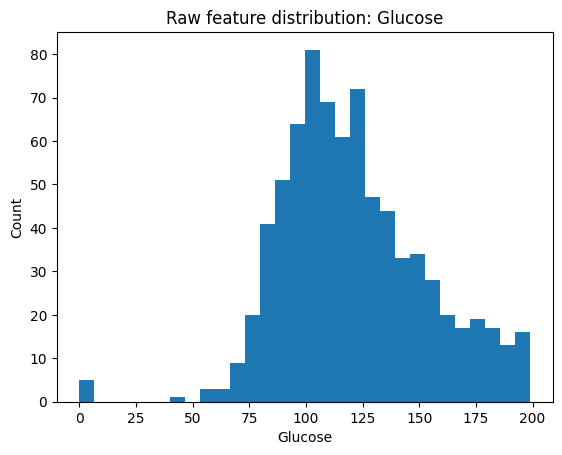

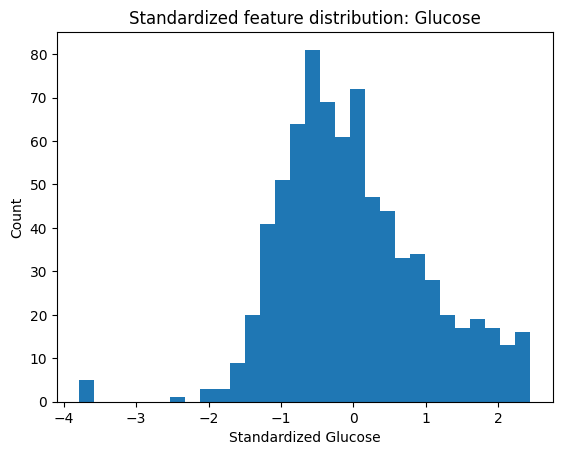

In [13]:
# Visualizing a single transformation: standardization effect on one feature
feature = "Glucose"
x_raw = df[feature].astype(float).to_numpy()

sc = StandardScaler()
x_scaled = sc.fit_transform(x_raw.reshape(-1, 1)).ravel()

plt.figure()
plt.hist(x_raw, bins=30)
plt.title("Raw feature distribution: Glucose")
plt.xlabel("Glucose")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(x_scaled, bins=30)
plt.title("Standardized feature distribution: Glucose")
plt.xlabel("Standardized Glucose")
plt.ylabel("Count")
plt.show()



### Saving fitted pipelines (one artifact for preprocessing + model)

When you call `joblib.dump` on a fitted pipeline, you capture:

- fitted preprocessing parameters,
- fitted model parameters,
- and the exact wiring between them.

This is the simplest route to consistent inference later.

In a GitHub tutorial repository, it is usually better to **show** serialization as a technique, but avoid committing large binary artifacts to the repository unless you have a clear MLOps plan (e.g., Git LFS, model registry).



In [14]:
# Serialization: save a fully-fitted pipeline (preprocessing + model)
import joblib

pipe.fit(X_train, y_train)
joblib.dump(pipe, "Chapter2_Lesson13_diabetes_pipeline.joblib")


['Chapter2_Lesson13_diabetes_pipeline.joblib']


### Training/serving consistency (why a single serialized pipeline matters)

A frequent failure mode in real systems is *training-serving skew*:

- Training code applies preprocessing version A.
- Serving code applies preprocessing version B (or forgets a step).
- Model performance in production collapses.

If you serialize a single object that includes both preprocessing and model, then:

- training and inference use the same transformations,
- versioning is simpler (one artifact),
- audits become easier (“what exactly produced this prediction?”).

This is one reason why even in purely academic work, you should treat pipelines as first-class artifacts.

---

### Caching expensive transforms (optional)

Some transforms are expensive (text vectorization, large one-hot expansions). `Pipeline` supports caching via `memory=...` (joblib). For long experiments, caching can reduce runtime significantly. Use it only when inputs are stable and you understand the trade-offs.

---

### Summary

- Put all learned preprocessing steps inside a pipeline.
- Use `ColumnTransformer` for mixed-type tables.
- Validate with cross-validation on the pipeline object.
- Tune hyperparameters with `GridSearchCV` around the pipeline.
- Serialize the fitted pipeline for reproducible inference.




### Exercises (recommended)

1. **Leakage stress test (diabetes)**
   - Add an imputer step and intentionally fit it outside the pipeline.
   - Measure how cross-validation ROC–AUC changes.
   - Explain why the difference occurs.

2. **Robust mixed-type regression (house prices)**
   - Replace `Ridge` with a tree-based regressor (e.g., `RandomForestRegressor`).
   - Observe which preprocessing steps become less critical and why.
   - Compare RMSE and training time.

3. **High-cardinality categorical features**
   - In a dataset with many categories, compare:
     - one-hot encoding,
     - hashing (via `FeatureHasher` or similar),
     - grouping rare categories (if supported).
   - Evaluate performance and memory footprint.

4. **Pipeline portability**
   - Fit a pipeline, serialize it with `joblib`, reload it, and run `predict` on a held-out sample.
   - Verify that reloaded predictions match exactly.

5. **Create your own transformer**
   - Implement a transformer that adds:
     - a ratio feature (e.g., $\frac{\text{Insulin}}{\text{Glucose}+\epsilon}$),
     - and a clipped version of BMI.
   - Insert it into a pipeline and validate with cross-validation.

